# Reinforced learning, työllistyminen ja Suomen sosiaaliturva

Tässä tehdään laskelmat artikkelia varten. Käytössä on gym-ympäristö _unemployment-v1_ , johon on toteutettu yksityiskohtaisesti sosiaaliturvaa eri tiloissa.

In [1]:
# for Colab, install fin_benefits and unemployment-gym from Github
#!pip install -q git+https://github.com/ajtanskanen/benefits.git  
#!pip install -q git+https://github.com/ajtanskanen/econogym.git
#!pip install -q git+https://github.com/ajtanskanen/lifecycle-rl.git

# and then restart kernel
  
  # For a specific version:
#!pip install tensorflow==1.15
#!pip install stable-baselines==2.8
  
# restart kernel after running pip's

In [2]:
#import sys
#print(sys.path)
#sys.path.append('/usr/local/python3.7/site-packages')

Then load all modules and set parameters for simulations.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from lifecycle_rl import Lifecycle

%matplotlib inline
%pylab inline

# varoitukset piiloon (Stable baseline ei ole vielä Tensorflow 2.0-yhteensopiva, ja Tensorflow 1.15 valittaa paljon)
# ei taida toimia piilottaminen
import warnings
warnings.filterwarnings('ignore')


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Populating the interactive namespace from numpy and matplotlib


In [4]:
## parameters for the simulation
# episode = 51 / 205 timesteps (1y/3m timestep)
pop_size=100_000 # size of the population to be simulated
size1=10_000_000 # number of timesteps in phase 1 training (callback not used)
size2=100_000_000 #0_000 # number of timesteps in phase 2 training (callback is used to save the best results)
size3=20_000_000 # number of timesteps in phase 1 training (callback not used) for policy changes
batch1=1_00 # size of minibatch in phase 1 as number of episodes
batch2=9_00  # size of minibatch in phase 1 as number of episodes
callback_minsteps=batch2 # how many episodes callback needs 
deterministic=False # use deterministic prediction (True) or probabilitic prediction (False)
mortality=False # include mortality in computations
randomness=True # include externally given, random state-transitions (parental leaves, disability, lay-offs) 
pinkslip=True # include lay-offs at 5 percent level each year
rlmodel='acktr' # use ACKTR algorithm
twostage=False # ajataan kahdessa vaiheessa vai ei
#perusmalli_start='best/malli_baseline'
perusmalli_start='best/malli_baseline_v100'
perusmalli9='best/malli_baseline9'
perusresults='results/baseline_results'
prefmalli='best/malli_perus_prefnoise'
prefresults='results/perus_results_prefnoise'
debug=False # jos True, niin ajetaan vain yhdellä prosessilla. Nopeampi debugata.
plotdebug=False # tulostetaanko rivi riviltä mitä tapahtuu

# Nykymalli 

Lasketaan työllisyysasteet nykymallissa.

plotdebug False
No mortality included
False
Parameters of lifecycle:
timestep 0.25
gamma 0.9793703613355593 (0.9200000000000003 per anno)
min_age 20
max_age 70
min_retirementage 63.5
max_retirementage 68
ansiopvraha_kesto300 300
ansiopvraha_kesto400 400
ansiopvraha_toe 0.5
perustulo False
karenssi_kesto 0.25
mortality False
randomness True
include_putki True
include_pinkslip True

simulate
simulating  best/malli_baseline_v100
predicting...




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Rahavirrat skaalattuna väestötasolle
+------------------+----------------------+----------------------+----------------------+
|                  |                  e/v |              toteuma |                  ero |
|------------------+----------------------+----------------------+----------------------|
| palkkatulo       | 87,961,418,417.22    | 89,134,200,000.00    | -1,172,781,582.78    |
| etuusmeno        | 42,099,612,658.86    | 36,945,147,749.00    |  5,154,464,909.86    |
| verot+maksut     | 30,948,002,294.04    | 30,763,000,000.00    |    185,002,294.04    |
| muut tulot       | 11,151,610,364.81    |  6,182,147,749.00    |  4,969,462,615.81    |
| valtionvero      |  3,256,212,670.57    |  5,542,000,000.00    | -2,285,787,329.43    |
| kunnallisvero    | 18,766,379,917.70    | 18,991,000,000.00    |   -224,620,082.30    |
| ptel             |  5,483,878,795.79    |  5,560,000,000.00    |    -76,121,204.21    |
| tyotvakmaksu     |  1,671,266,949.93    |  1,693,549,800.00  

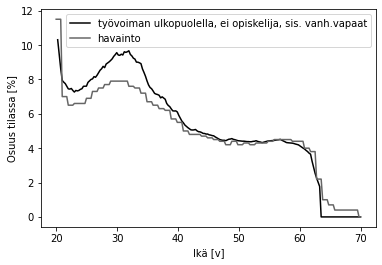

yht [        nan 10.3074123   9.47137886  8.62234489  7.94131765  7.83831353
  7.75631025  7.60230409  7.45029801  7.43529741  7.47229889  7.35729429
  7.26429057  7.35629425  7.33129325  7.35729429  7.42329693  7.45529821
  7.60030401  7.60330413  7.60830433  7.82631305  7.91331653  7.99731989
  8.03032121  8.16132645  8.12532501  8.24232969  8.38233529  8.53434137
  8.61834473  8.75935037  8.68434737  8.89235569  8.95635825  9.02236089
  9.10536421  9.19736789  9.33837353  9.43837754  9.55638226  9.41937678
  9.40037602  9.46637866  9.41937678  9.6073843   9.57338294  9.60838434
  9.66438658  9.45037802  9.36637465  9.23336933  9.18336733  9.00436017
  9.00136005  8.96535861  8.91635665  8.60734429  8.40233609  8.18032721
  7.91031641  7.67830713  7.52930117  7.45929837  7.32929317  7.18628745
  7.14328573  7.11928477  7.07528301  6.92527701  6.98527941  6.91727669
  6.84527381  6.60126405  6.48525941  6.41625665  6.28625145  6.17024681
  6.16224649  6.16824673  6.10524421  5.9052362

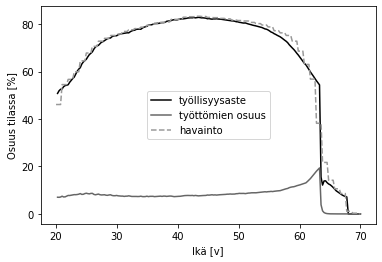

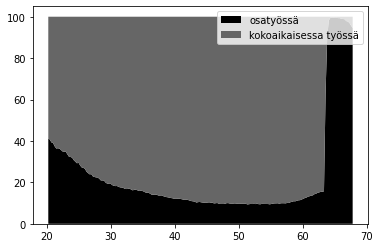

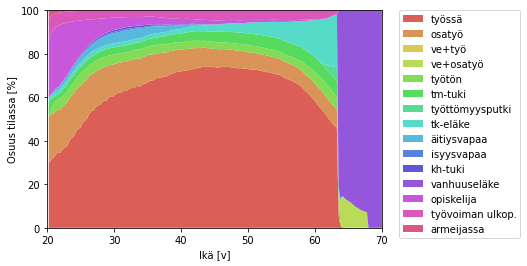

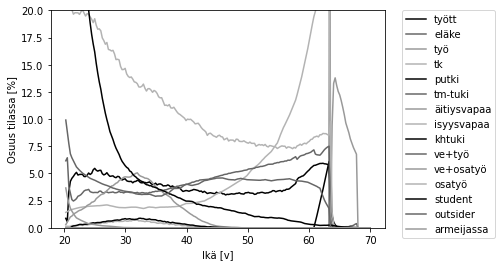

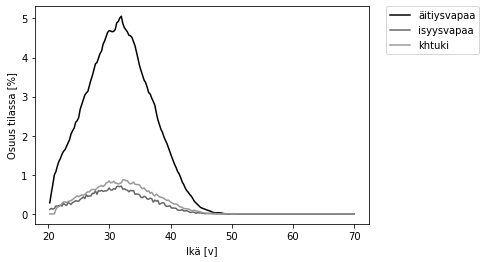

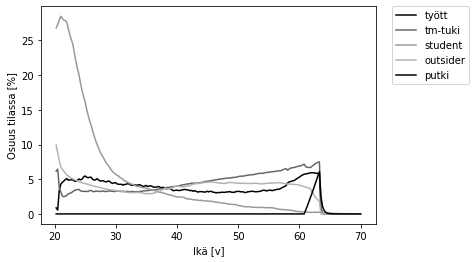

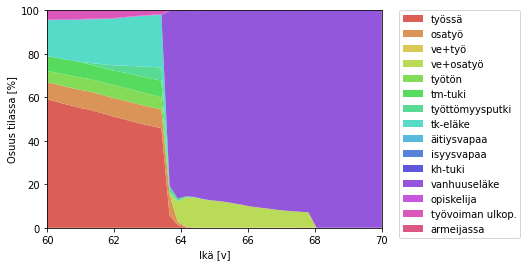

Lisäpäivillä on 6896 henkilöä


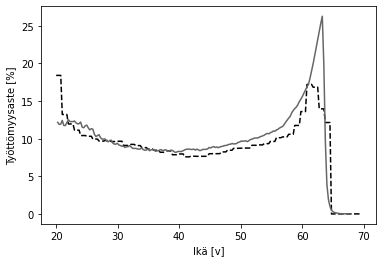

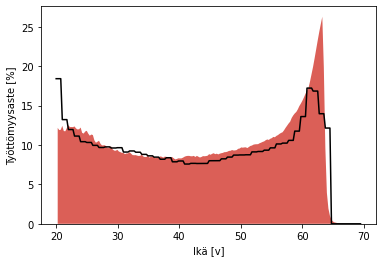

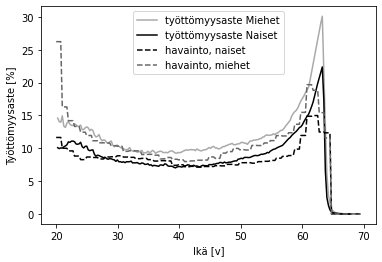

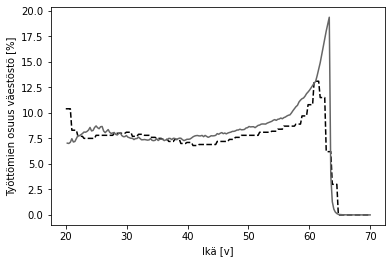

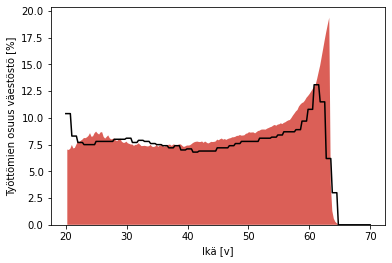

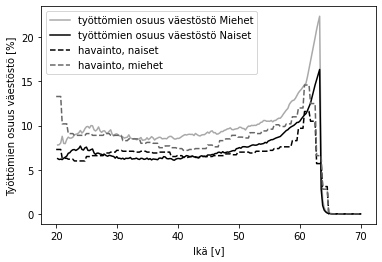

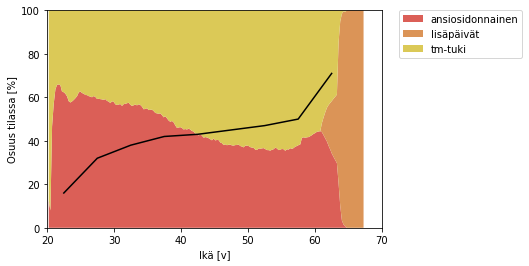

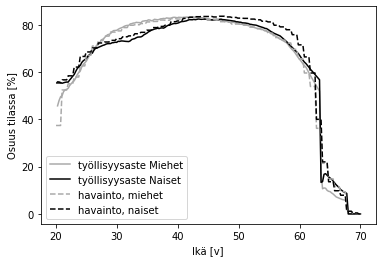

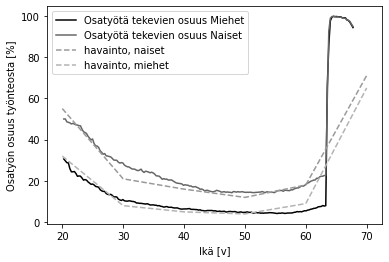

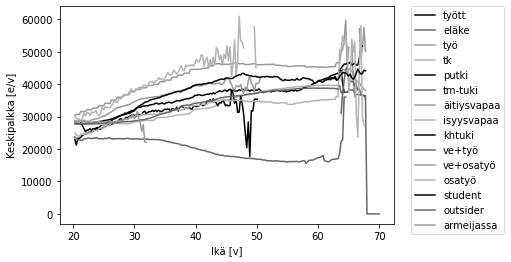

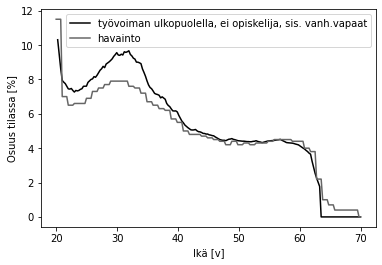

yht [        nan 10.3074123   9.47137886  8.62234489  7.94131765  7.83831353
  7.75631025  7.60230409  7.45029801  7.43529741  7.47229889  7.35729429
  7.26429057  7.35629425  7.33129325  7.35729429  7.42329693  7.45529821
  7.60030401  7.60330413  7.60830433  7.82631305  7.91331653  7.99731989
  8.03032121  8.16132645  8.12532501  8.24232969  8.38233529  8.53434137
  8.61834473  8.75935037  8.68434737  8.89235569  8.95635825  9.02236089
  9.10536421  9.19736789  9.33837353  9.43837754  9.55638226  9.41937678
  9.40037602  9.46637866  9.41937678  9.6073843   9.57338294  9.60838434
  9.66438658  9.45037802  9.36637465  9.23336933  9.18336733  9.00436017
  9.00136005  8.96535861  8.91635665  8.60734429  8.40233609  8.18032721
  7.91031641  7.67830713  7.52930117  7.45929837  7.32929317  7.18628745
  7.14328573  7.11928477  7.07528301  6.92527701  6.98527941  6.91727669
  6.84527381  6.60126405  6.48525941  6.41625665  6.28625145  6.17024681
  6.16224649  6.16824673  6.10524421  5.9052362

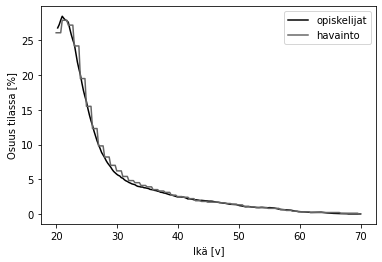

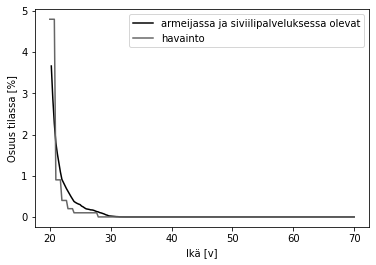

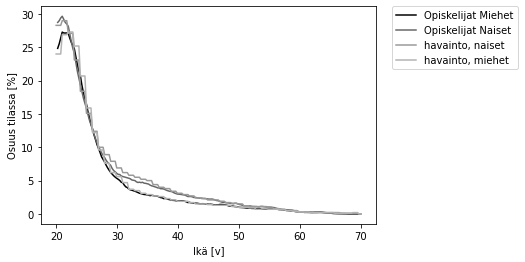

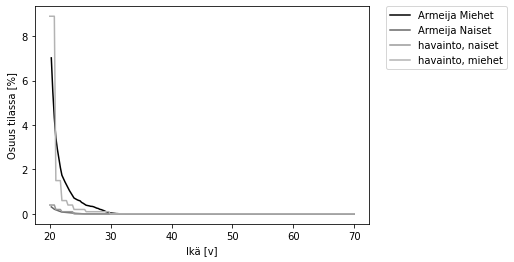

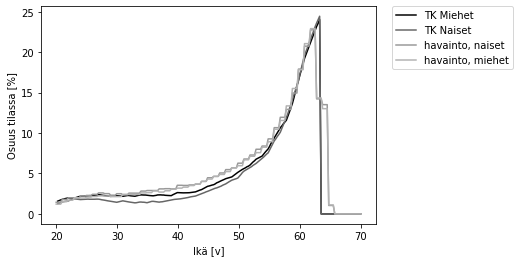

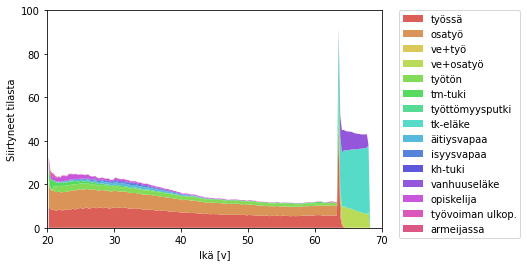

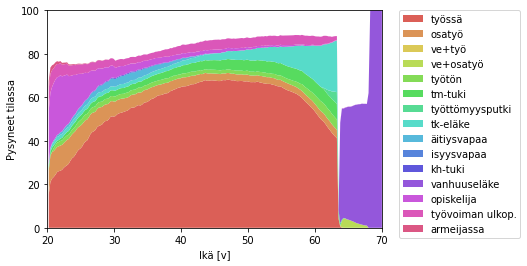

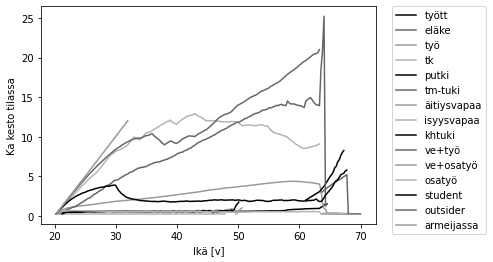

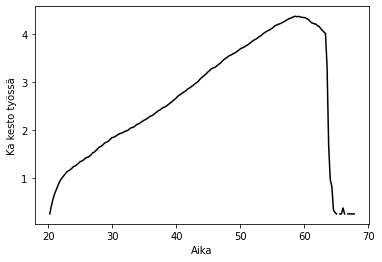

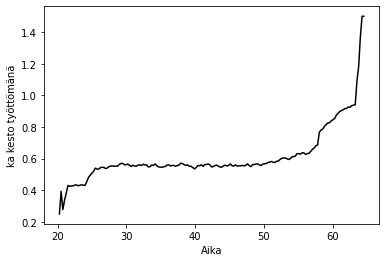

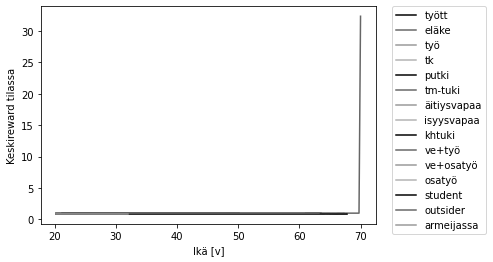

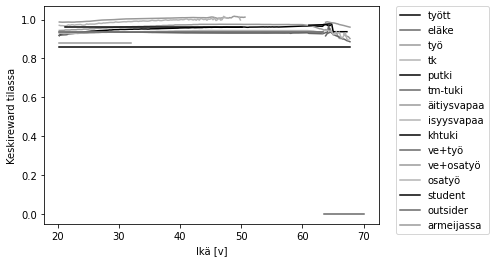

No handles with labels found to put in legend.


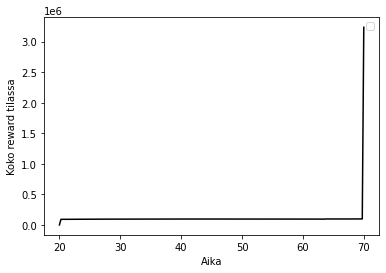

yhteensä reward 223.75831861777812


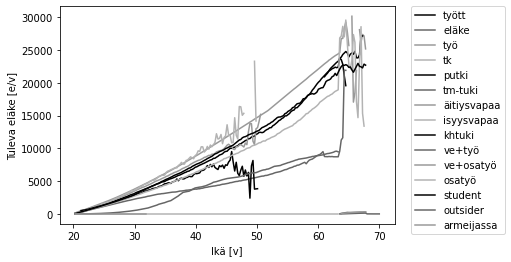

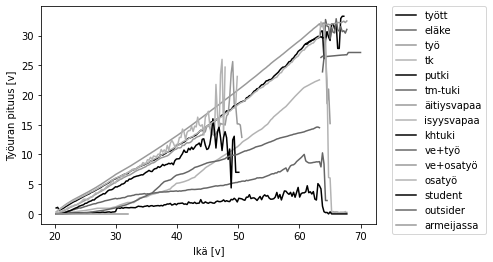

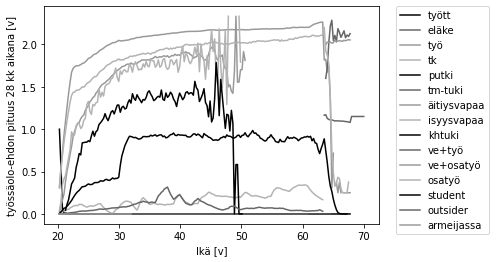

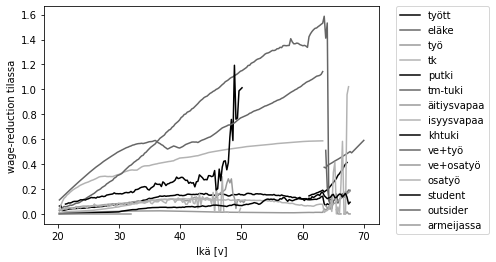

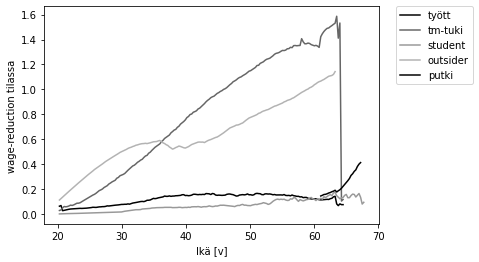

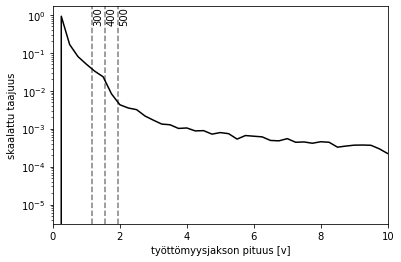

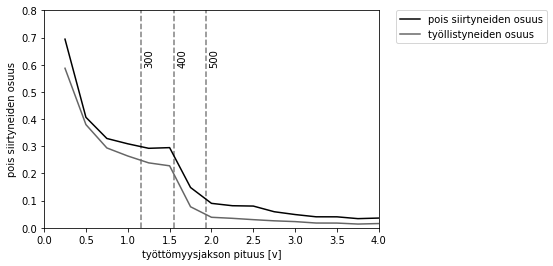

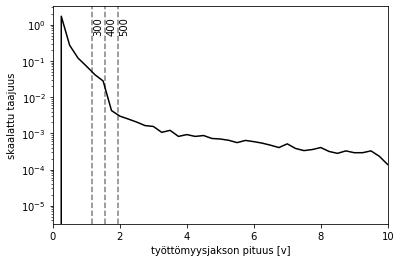

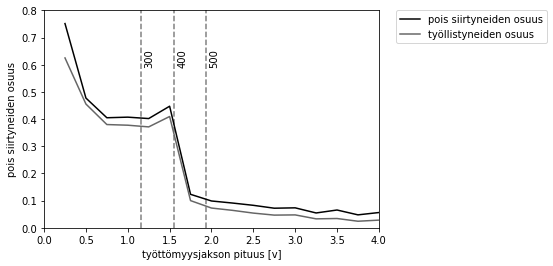

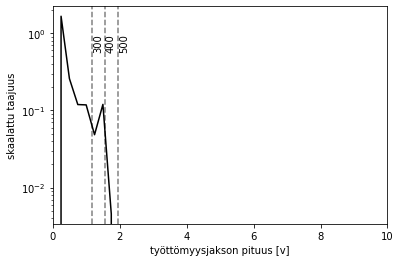

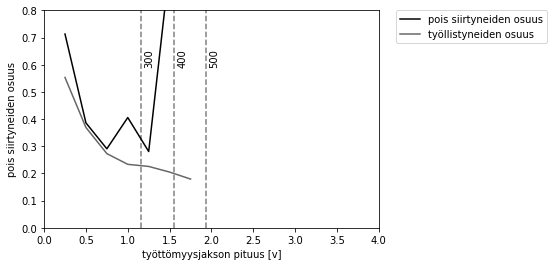

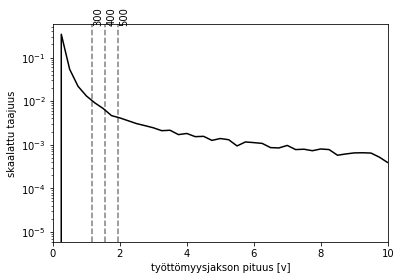

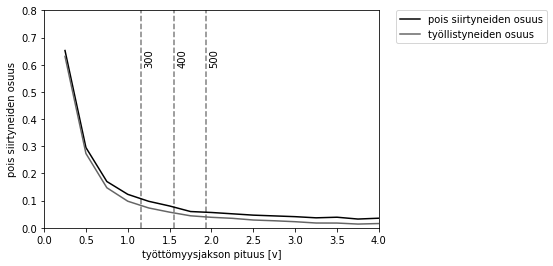

In [4]:
cc1=Lifecycle(env='unemployment-v1',minimal=False,mortality=mortality,perustulo=False,
              randomness=randomness,pinkslip=pinkslip,plotdebug=plotdebug)
cc1.run_results(debug=debug,steps1=size1,steps2=size2,pop=pop_size,deterministic=deterministic,
                train=False,predict=True,batch1=batch1,batch2=batch2,
                save=perusmalli_start,plot=True,cont=True,start_from=perusmalli_start,results=perusresults,
                callback_minsteps=callback_minsteps,rlmodel=rlmodel,twostage=twostage)

plotdebug False
No mortality included
False
Parameters of lifecycle:
timestep 0.25
gamma 0.9793703613355593 (0.9200000000000003 per anno)
min_age 20
max_age 70
min_retirementage 63.5
max_retirementage 68
ansiopvraha_kesto300 300
ansiopvraha_kesto400 400
ansiopvraha_toe 0.5
perustulo False
karenssi_kesto 0.25
mortality False
randomness True
include_putki True
include_pinkslip True



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


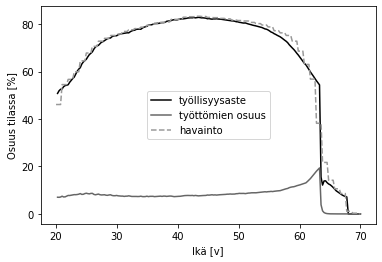

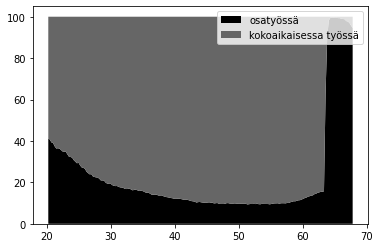

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


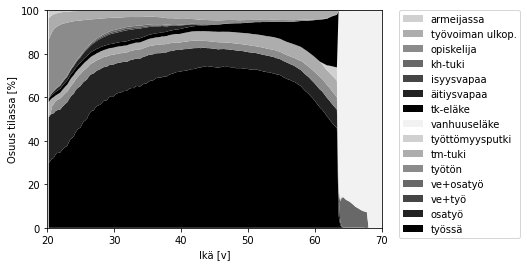

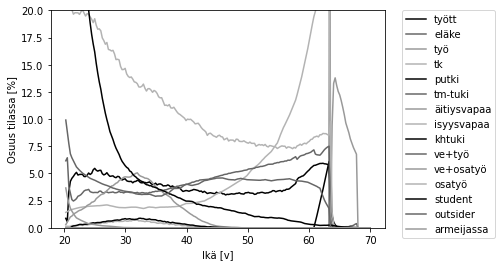

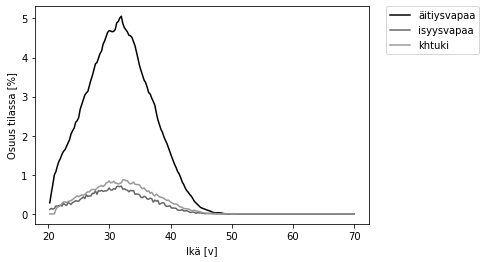

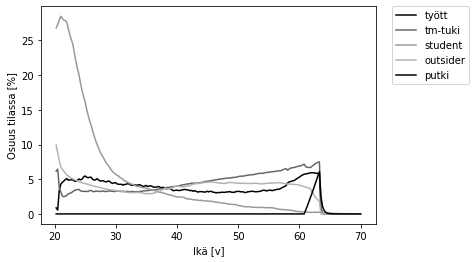

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


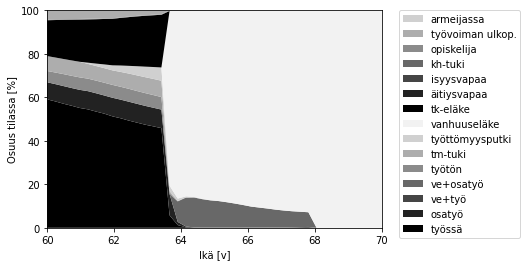

Rahavirrat skaalattuna väestötasolle
+------------------+----------------------+----------------------+----------------------+
|                  |                  e/v |              toteuma |                  ero |
|------------------+----------------------+----------------------+----------------------|
| palkkatulo       | 87,961,418,417.22    | 89,134,200,000.00    | -1,172,781,582.78    |
| etuusmeno        | 42,099,612,658.86    | 36,945,147,749.00    |  5,154,464,909.86    |
| verot+maksut     | 30,948,002,294.04    | 30,763,000,000.00    |    185,002,294.04    |
| muut tulot       | 11,151,610,364.81    |  6,182,147,749.00    |  4,969,462,615.81    |
| valtionvero      |  3,256,212,670.57    |  5,542,000,000.00    | -2,285,787,329.43    |
| kunnallisvero    | 18,766,379,917.70    | 18,991,000,000.00    |   -224,620,082.30    |
| ptel             |  5,483,878,795.79    |  5,560,000,000.00    |    -76,121,204.21    |
| tyotvakmaksu     |  1,671,266,949.93    |  1,693,549,800.00  

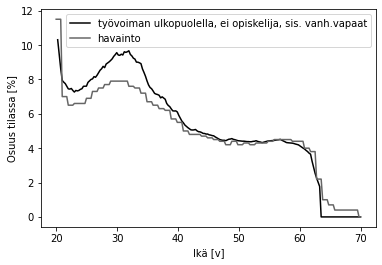

yht [        nan 10.3074123   9.47137886  8.62234489  7.94131765  7.83831353
  7.75631025  7.60230409  7.45029801  7.43529741  7.47229889  7.35729429
  7.26429057  7.35629425  7.33129325  7.35729429  7.42329693  7.45529821
  7.60030401  7.60330413  7.60830433  7.82631305  7.91331653  7.99731989
  8.03032121  8.16132645  8.12532501  8.24232969  8.38233529  8.53434137
  8.61834473  8.75935037  8.68434737  8.89235569  8.95635825  9.02236089
  9.10536421  9.19736789  9.33837353  9.43837754  9.55638226  9.41937678
  9.40037602  9.46637866  9.41937678  9.6073843   9.57338294  9.60838434
  9.66438658  9.45037802  9.36637465  9.23336933  9.18336733  9.00436017
  9.00136005  8.96535861  8.91635665  8.60734429  8.40233609  8.18032721
  7.91031641  7.67830713  7.52930117  7.45929837  7.32929317  7.18628745
  7.14328573  7.11928477  7.07528301  6.92527701  6.98527941  6.91727669
  6.84527381  6.60126405  6.48525941  6.41625665  6.28625145  6.17024681
  6.16224649  6.16824673  6.10524421  5.9052362

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


+-------+----------+-----------+------------+-----------+-------------+
|       |   0-6 kk |   6-12 kk |   12-18 kk |   18-24kk |   yli 24 kk |
|-------+----------+-----------+------------+-----------+-------------|
| 20-29 |     0.90 |      0.07 |       0.03 |      0.00 |        0.00 |
| 30-39 |     0.73 |      0.14 |       0.13 |      0.00 |        0.00 |
| 40-49 |     0.72 |      0.15 |       0.13 |      0.01 |        0.00 |
| 50-59 |     0.66 |      0.15 |       0.17 |      0.02 |        0.00 |
| 60-65 |     0.38 |      0.19 |       0.16 |      0.22 |        0.05 |
+-------+----------+-----------+------------+-----------+-------------+


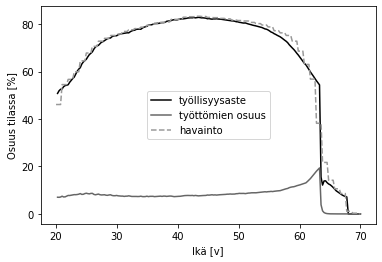

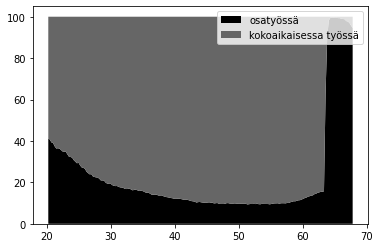

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


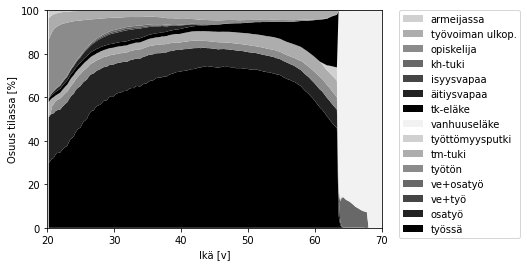

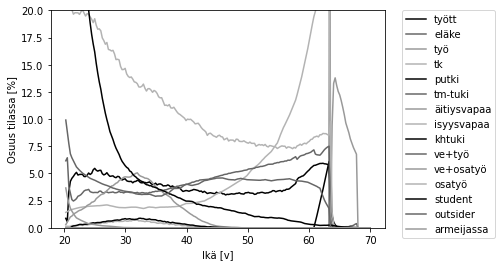

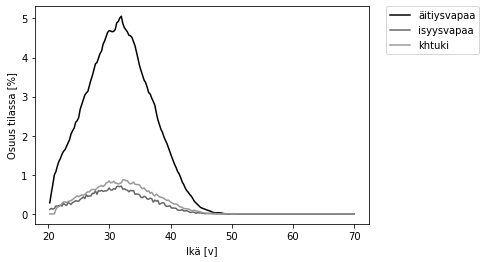

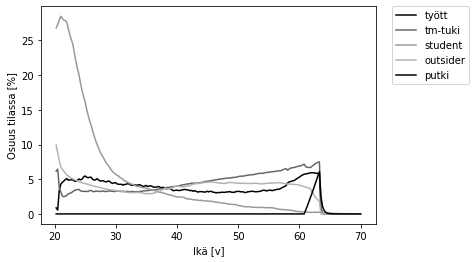

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


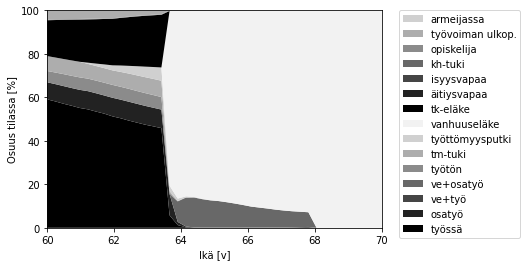

Lisäpäivillä on 6896 henkilöä


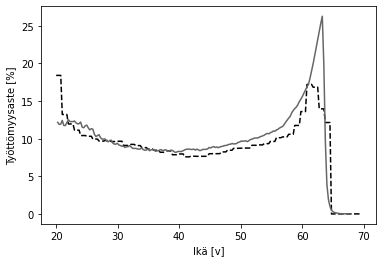

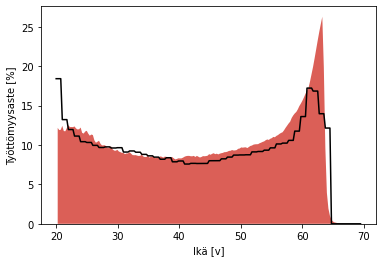

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


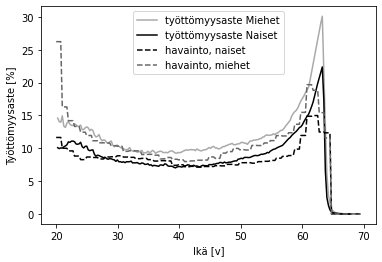

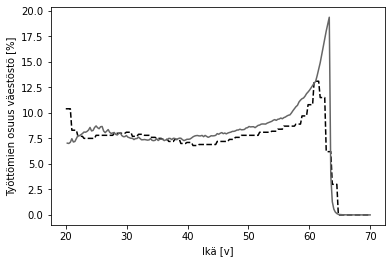

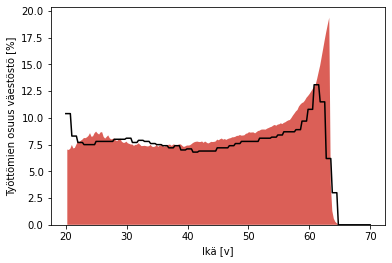

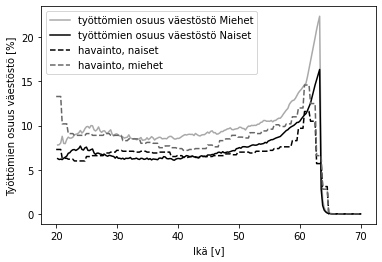

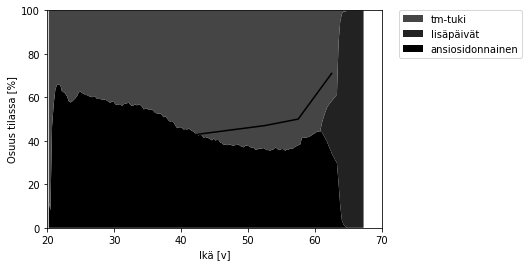

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


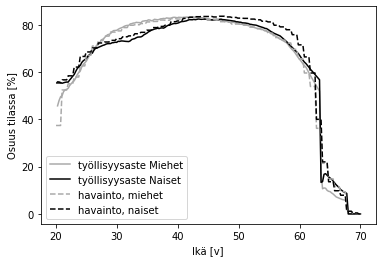

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


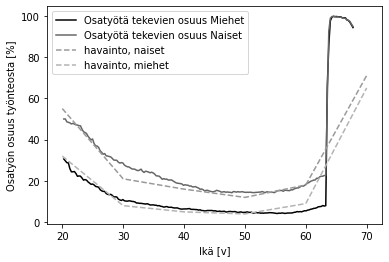

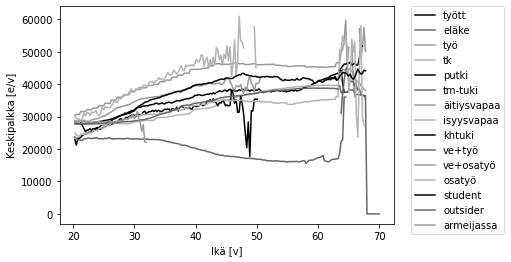

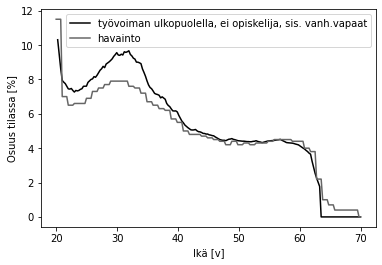

yht [        nan 10.3074123   9.47137886  8.62234489  7.94131765  7.83831353
  7.75631025  7.60230409  7.45029801  7.43529741  7.47229889  7.35729429
  7.26429057  7.35629425  7.33129325  7.35729429  7.42329693  7.45529821
  7.60030401  7.60330413  7.60830433  7.82631305  7.91331653  7.99731989
  8.03032121  8.16132645  8.12532501  8.24232969  8.38233529  8.53434137
  8.61834473  8.75935037  8.68434737  8.89235569  8.95635825  9.02236089
  9.10536421  9.19736789  9.33837353  9.43837754  9.55638226  9.41937678
  9.40037602  9.46637866  9.41937678  9.6073843   9.57338294  9.60838434
  9.66438658  9.45037802  9.36637465  9.23336933  9.18336733  9.00436017
  9.00136005  8.96535861  8.91635665  8.60734429  8.40233609  8.18032721
  7.91031641  7.67830713  7.52930117  7.45929837  7.32929317  7.18628745
  7.14328573  7.11928477  7.07528301  6.92527701  6.98527941  6.91727669
  6.84527381  6.60126405  6.48525941  6.41625665  6.28625145  6.17024681
  6.16224649  6.16824673  6.10524421  5.9052362

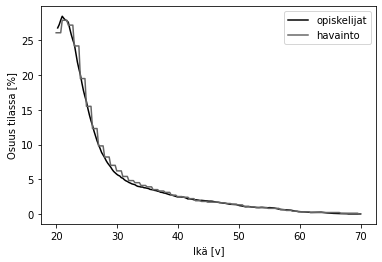

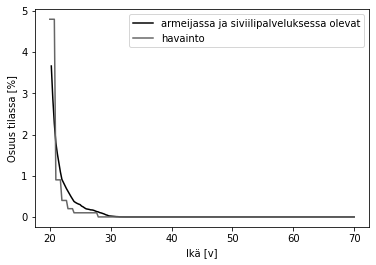

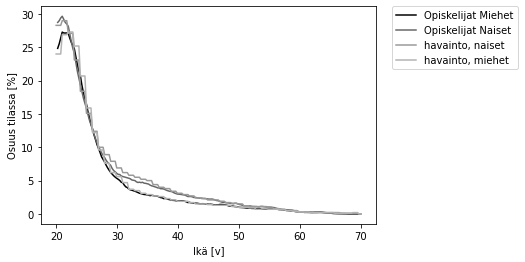

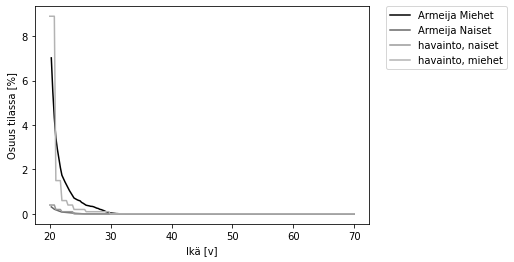

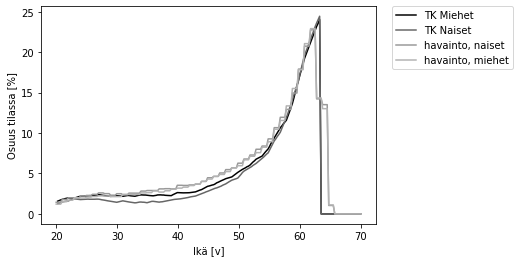

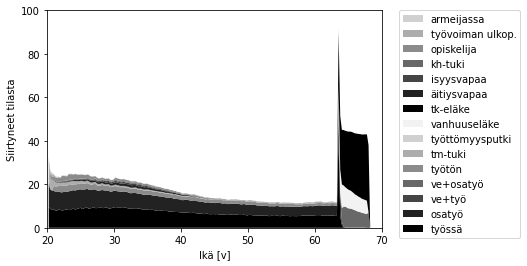

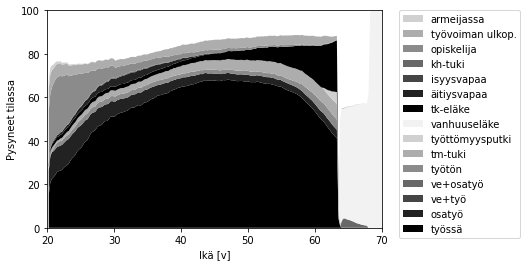

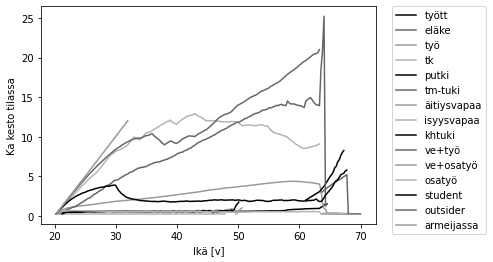

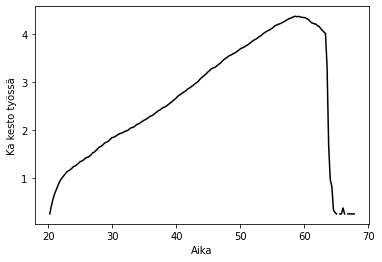

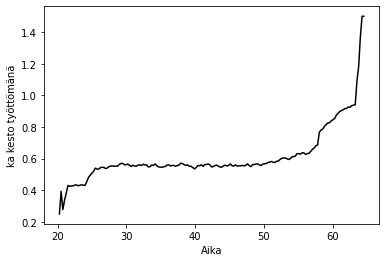

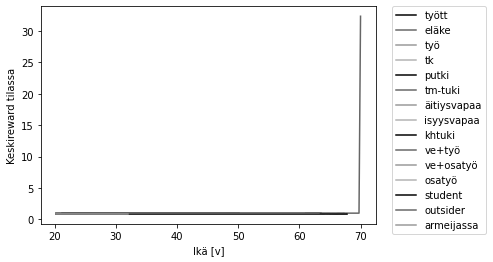

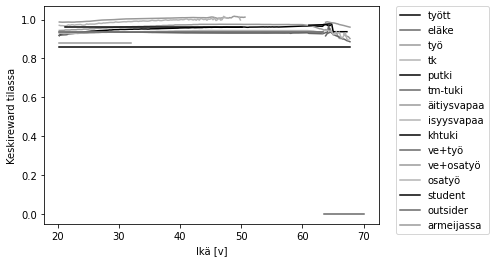

No handles with labels found to put in legend.


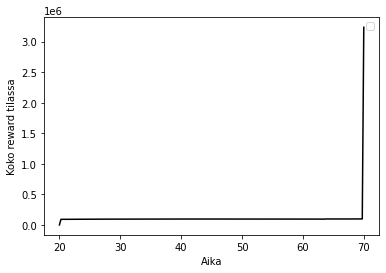

yhteensä reward 223.75831861777812


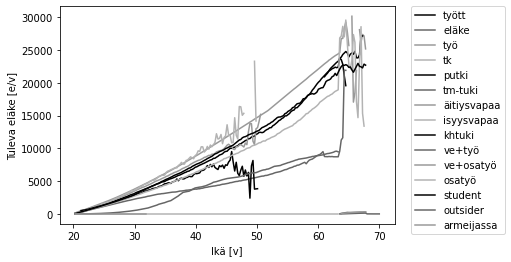

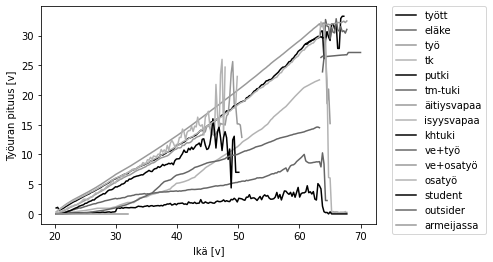

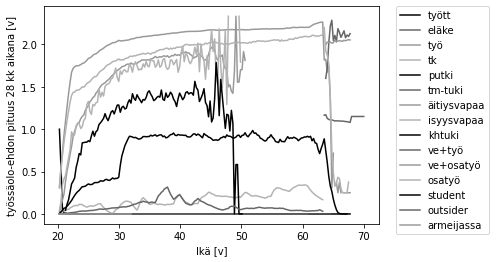

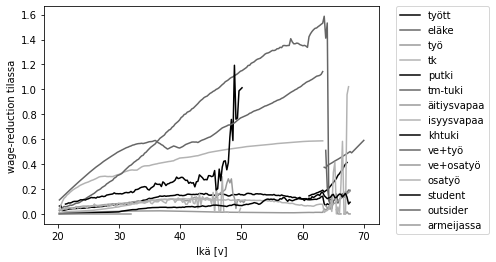

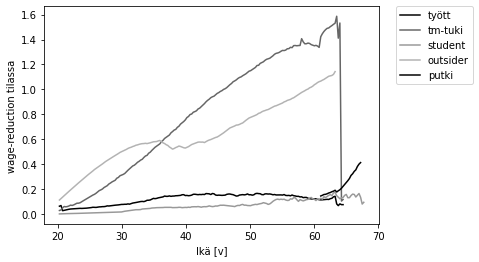

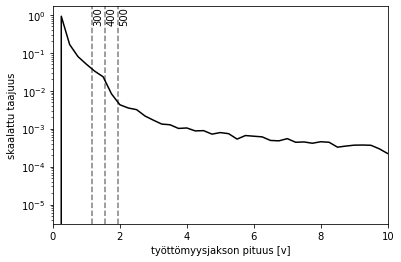

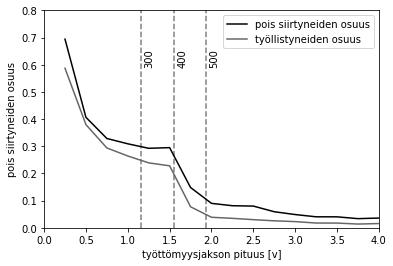

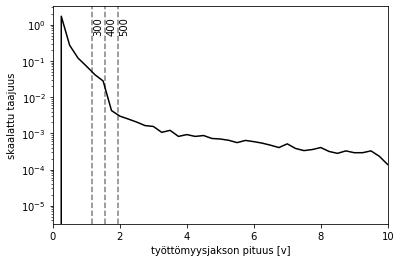

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


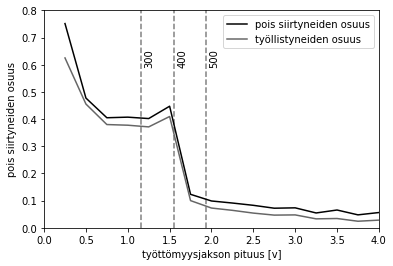

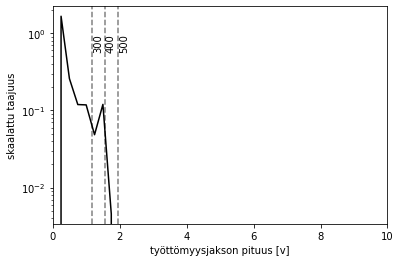

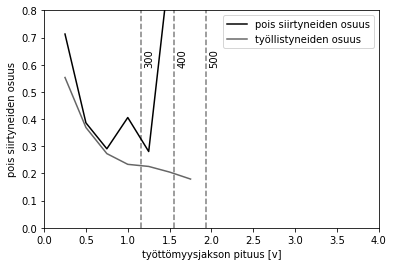

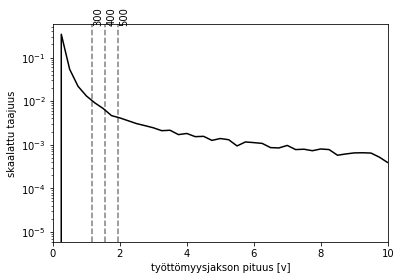

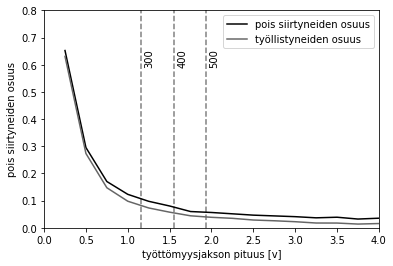

In [5]:
cc1b=Lifecycle(env='unemployment-v1',minimal=False,mortality=mortality,perustulo=False,
              randomness=randomness,pinkslip=pinkslip,plotdebug=False)
cc1b.render(load=perusresults,figname='perus_')
#cc1b.load_sim(load=perusresults)

plotdebug False
No mortality included
False
Parameters of lifecycle:
timestep 0.25
gamma 0.9793703613355593 (0.9200000000000003 per anno)
min_age 20
max_age 70
min_retirementage 63.5
max_retirementage 68
ansiopvraha_kesto300 300
ansiopvraha_kesto400 400
ansiopvraha_toe 0.5
perustulo False
karenssi_kesto 0.25
mortality False
randomness True
include_putki True
include_pinkslip True

Rahavirrat skaalattuna väestötasolle
+------------------+-------+----------------------+-----------------------+
|                  |   e/v |              toteuma |                   ero |
|------------------+-------+----------------------+-----------------------|
| palkkatulo       |  0.00 | 89,134,200,000.00    | -89,134,200,000.00    |
| etuusmeno        |  0.00 | 36,945,147,749.00    | -36,945,147,749.00    |
| verot+maksut     |  0.00 | 30,763,000,000.00    | -30,763,000,000.00    |
| muut tulot       |  0.00 |  6,182,147,749.00    |  -6,182,147,749.00    |
| valtionvero      |  0.00 |  5,542,000,000.00 

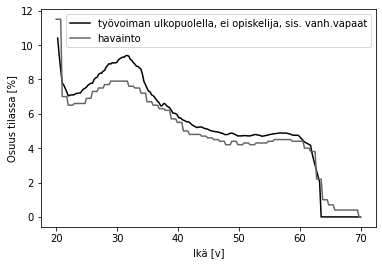

yht [        nan 10.40341614  9.40337614  8.56834273  7.79931197  7.67530701
  7.47729909  7.26929077  7.03728149  7.07928317  7.09628385  7.09528381
  7.11228449  7.18128725  7.18228729  7.20928837  7.20628825  7.33929357
  7.43429737  7.48229929  7.55230209  7.66430657  7.71830873  7.77631105
  7.78031121  7.98931957  8.08732349  8.11632465  8.28533141  8.36133445
  8.35833433  8.48233929  8.52334093  8.71534861  8.82235289  8.91935677
  8.89235569  8.96735869  8.95335813  8.96635865  8.98735949  9.12536501
  9.20036801  9.25137005  9.30037201  9.29037161  9.3823753   9.39137566
  9.35137405  9.16536661  9.10136405  8.97435897  8.89235569  8.76735069
  8.75935037  8.67434697  8.59034361  8.28833153  7.86631465  7.69130765
  7.48229929  7.32729309  7.27529101  7.10328413  7.05928237  6.96427857
  6.83027321  6.72226889  6.63726549  6.46325853  6.47425897  6.60026401
  6.57226289  6.46125845  6.40225609  6.34625385  6.20624825  6.04724189
  6.03124125  6.00924037  5.92223689  5.7612304

KeyboardInterrupt: 

In [3]:
cc2_porras=Lifecycle(env='unemployment-v1',minimal=False,mortality=mortality,perustulo=False,
              randomness=randomness,pinkslip=pinkslip,plotdebug=False)
cc2_porras.render(load='results/steps_results')
cc2_porras.load_sim(load='results/steps_results')
cc2_porras.compare_with(cc1b)

In [8]:
1.96*6370/10

1248.52

In [9]:
2_300_000*12*560

15456000000

In [10]:
15_456_000_000

15456000000